In [1]:
import json
from collections import Counter
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers.merge import Dot
from sklearn.linear_model import LinearRegression
import numpy as np
import random
from sklearn import svm

Using TensorFlow backend.


In [2]:
with open('data/wp_movies_10k.ndjson') as fin:
    movies = [json.loads(l) for l in fin]

In [3]:
movies[0][0], movies[0][1]

('Deadpool (film)',
 {'image': 'Deadpool poster.jpg',
  'name': 'Deadpool',
  'cinematography': 'Ken Seng',
  'Software Used': 'Adobe Premier Pro',
  'alt': "Official poster shows the titular hero Deadpool standing in front of the viewers, with hugging his hands, and donning his traditional black and red suit and mask, and the film's name, credits and billing below him.",
  'distributor': '20th Century Fox',
  'caption': 'Theatrical release poster',
  'gross': '$783.1 million',
  'country': 'United States',
  'director': 'Tim Miller',
  'runtime': '108 minutes',
  'editing': 'Julian Clarke',
  'language': 'English',
  'music': 'Tom Holkenborg',
  'budget': '$58 million'})

In [4]:
# outgoing links
movies[0][2]

['Tim Miller (director)',
 'Simon Kinberg',
 'Ryan Reynolds',
 'Lauren Shuler Donner',
 'Rhett Reese',
 'Paul Wernick',
 'Deadpool',
 'Fabian Nicieza',
 'Rob Liefeld',
 'Morena Baccarin',
 'Ed Skrein',
 'T.J. Miller',
 'Gina Carano',
 'Leslie Uggams',
 'Brianna Hildebrand',
 'Stefan Kapičić',
 'Junkie XL',
 'Julian Clarke',
 'Marvel Entertainment',
 'Kinberg Genre',
 'Lauren Shuler Donner',
 'TSG Entertainment',
 '20th Century Fox',
 'Le Grand Rex',
 'Variety (magazine)',
 'Box Office Mojo',
 'superhero film',
 'Tim Miller (director)',
 'Rhett Reese',
 'Paul Wernick',
 'Marvel Comics',
 'Deadpool',
 'X-Men (film series)',
 'Ryan Reynolds',
 'Morena Baccarin',
 'Ed Skrein',
 'T.J. Miller',
 'Gina Carano',
 'Leslie Uggams',
 'Brianna Hildebrand',
 'Stefan Kapičić',
 'antihero',
 'New Line Cinema',
 '20th Century Fox',
 'X-Men Origins: Wolverine',
 'principal photography',
 'Vancouver',
 'IMAX',
 'Digital Light Processing',
 'D-Box Technologies',
 'List of accolades received by Deadpool (

### count links over all movies with Counter()

In [5]:
link_counts = Counter()
for movie in movies:
    link_counts.update(movie[2])
link_counts.most_common(10)

[('Rotten Tomatoes', 9393),
 ('Category:English-language films', 5882),
 ('Category:American films', 5867),
 ('Variety (magazine)', 5450),
 ('Metacritic', 5112),
 ('Box Office Mojo', 4186),
 ('The New York Times', 3818),
 ('The Hollywood Reporter', 3553),
 ('Roger Ebert', 2707),
 ('Los Angeles Times', 2454)]

In [6]:
len(link_counts)

218029

In [7]:
top_links = [link for link, c in link_counts.items() if c >= 3] # only take links that occure at least 3 times
link_to_idx = {link: idx for idx, link in enumerate(top_links)}
movie_to_idx = {movie[0]: idx for idx, movie in enumerate(movies)}
pairs = []
for movie in movies:
    pairs.extend((link_to_idx[link], movie_to_idx[movie[0]]) for link in movie[2] if link in link_to_idx)
pairs_set = set(pairs)
len(pairs), len(top_links), len(movie_to_idx), len(pairs_set)

(949544, 66913, 10000, 671403)

In [27]:
link_to_idx, movie_to_idx, pairs

({'Tim Miller (director)': 0,
  'Simon Kinberg': 1,
  'Ryan Reynolds': 2,
  'Lauren Shuler Donner': 3,
  'Rhett Reese': 4,
  'Paul Wernick': 5,
  'Deadpool': 6,
  'Morena Baccarin': 7,
  'Ed Skrein': 8,
  'T.J. Miller': 9,
  'Gina Carano': 10,
  'Leslie Uggams': 11,
  'Brianna Hildebrand': 12,
  'Stefan Kapičić': 13,
  'Junkie XL': 14,
  'Julian Clarke': 15,
  'Marvel Entertainment': 16,
  'Kinberg Genre': 17,
  'TSG Entertainment': 18,
  '20th Century Fox': 19,
  'Le Grand Rex': 20,
  'Variety (magazine)': 21,
  'Box Office Mojo': 22,
  'superhero film': 23,
  'Marvel Comics': 24,
  'X-Men (film series)': 25,
  'antihero': 26,
  'New Line Cinema': 27,
  'X-Men Origins: Wolverine': 28,
  'principal photography': 29,
  'Vancouver': 30,
  'IMAX': 31,
  'D-Box Technologies': 32,
  'Golden Globe Award': 33,
  'Golden Globe Award for Best Motion Picture – Musical or Comedy': 34,
  'Golden Globe Award for Best Actor – Motion Picture Musical or Comedy': 35,
  'Producers Guild of America Award

## Matrix that maps movie pages and outgoing links

**pairs** is nothing else then a big list containing all matrix entries that map **link_to_idx** and **movie_to_idx**

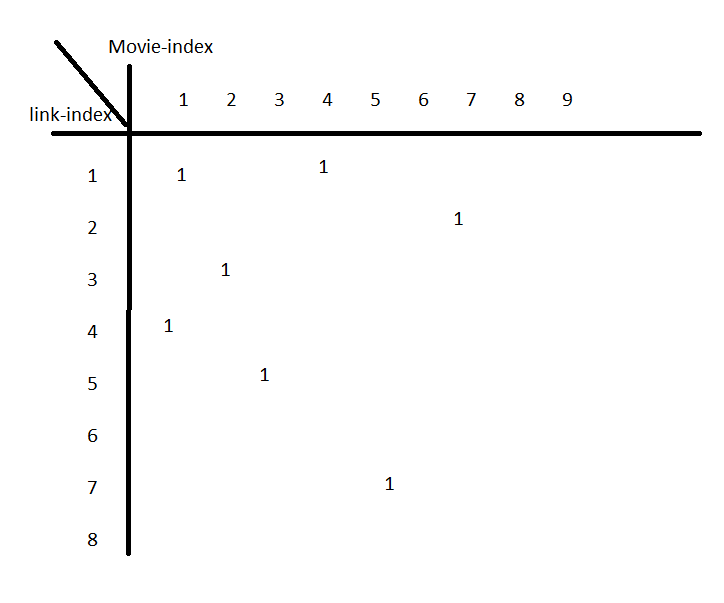

### Embeddings
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

Turns positive integers (indexes) into dense vectors of fixed size.
Our inputs for the network is a tuple of form
* link-id
* movie-id
* output (1=movie has link / -1=movie does not have this link)

Embedding converts each of these one hot encoded values in a very high dim space into a smaller so called **embedding space**

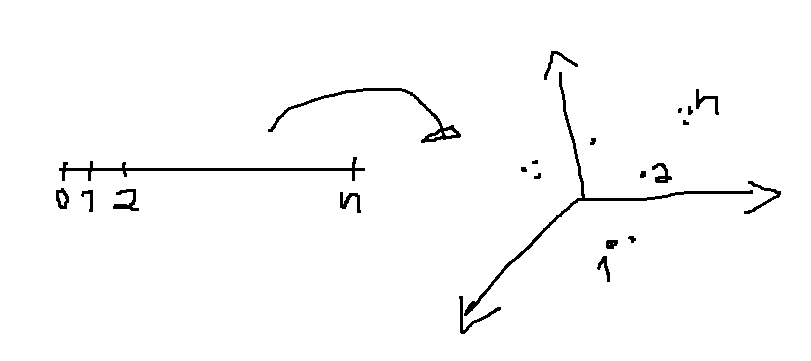

In [8]:
def movie_embedding_model(embedding_size=50):
    link = Input(name='link', shape=(1,))
    movie = Input(name='movie', shape=(1,))
    link_embedding = Embedding(name='link_embedding', 
                               input_dim=len(top_links), 
                               output_dim=embedding_size)(link)
    movie_embedding = Embedding(name='movie_embedding', 
                                input_dim=len(movie_to_idx), 
                                output_dim=embedding_size)(movie)
    dot = Dot(name='dot_product', normalize=True, axes=2)([link_embedding, movie_embedding])
    merged = Reshape((1,))(dot)
    model = Model(inputs=[link, movie], outputs=[merged])
    model.compile(optimizer='nadam', loss='mse')
    return model

model = movie_embedding_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        3345650     link[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        500000      movie[0][0]                      
_____________________________________

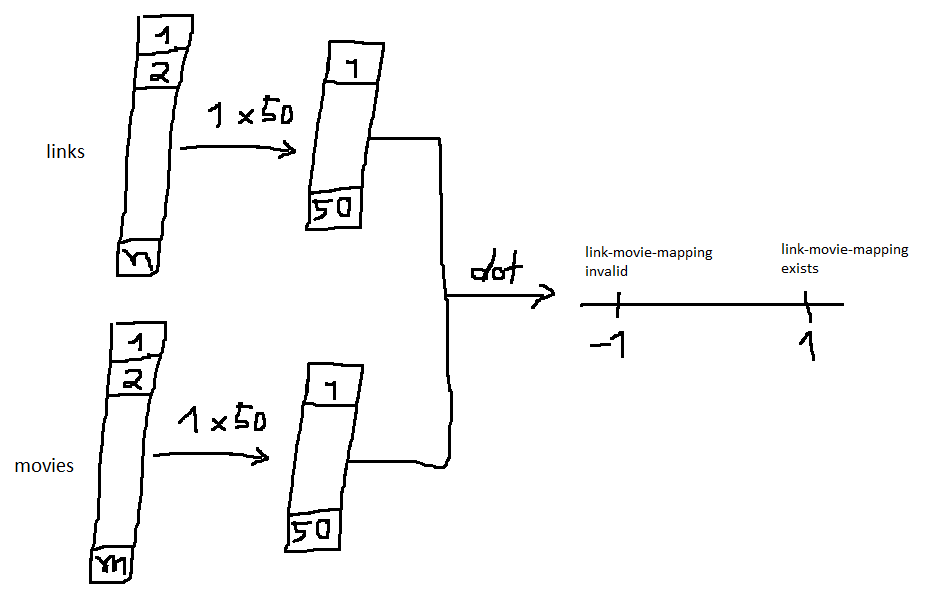

In [9]:
random.seed(5)

def batchifier(pairs, positive_samples=50, negative_ratio=10):
    """
    :param: positive_samples: number of positive samples
    :param: negative_ratio: if 2, negative samples will be doubled size of positive samples
    """
    batch_size = positive_samples * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    while True:
        for idx, (link_id, movie_id) in enumerate(random.sample(pairs, positive_samples)):
            batch[idx, :] = (link_id, movie_id, 1)
        idx = positive_samples
        while idx < batch_size:
            movie_id = random.randrange(len(movie_to_idx))
            link_id = random.randrange(len(top_links))
            if not (link_id, movie_id) in pairs_set:
                batch[idx, :] = (link_id, movie_id, -1)
                idx += 1
        np.random.shuffle(batch)
        yield {'link': batch[:, 0], 'movie': batch[:, 1]}, batch[:, 2]

next(batchifier(pairs, positive_samples=3, negative_ratio=2))

({'link': array([ 3801.,  1313., 48731., 20558., 32318., 13365., 32643., 22418.,
         31254.]),
  'movie': array([5874., 7236., 1854.,  849., 7685., 6238., 7628., 1529., 5530.])},
 array([-1.,  1., -1., -1., -1., -1., -1.,  1.,  1.]))

In [10]:
positive_samples_per_batch = 512

model.fit_generator(
    batchifier(pairs, positive_samples=positive_samples_per_batch, negative_ratio=10),
    epochs=15,
    steps_per_epoch=len(pairs) // positive_samples_per_batch,
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 67s - loss: 0.3813
Epoch 2/15
 - 65s - loss: 0.2354
Epoch 3/15
 - 66s - loss: 0.2294
Epoch 4/15
 - 65s - loss: 0.2264
Epoch 5/15
 - 66s - loss: 0.2252
Epoch 6/15
 - 66s - loss: 0.2243
Epoch 7/15
 - 66s - loss: 0.2239
Epoch 8/15
 - 66s - loss: 0.2231
Epoch 9/15
 - 66s - loss: 0.2220
Epoch 10/15
 - 66s - loss: 0.2219
Epoch 11/15
 - 66s - loss: 0.2207
Epoch 12/15
 - 66s - loss: 0.2222
Epoch 13/15
 - 66s - loss: 0.2208
Epoch 14/15
 - 66s - loss: 0.2199
Epoch 15/15
 - 66s - loss: 0.2207


### Embeddings - what was learned?

During training a 10000 x 50 dim matrix was trained containing all weights to transform the movie-space (10.000 movies) into the embedding space (50) embeddings

In [25]:
movie = model.get_layer('movie_embedding')
movie_weights = movie.get_weights()[0] # 10000 x 50 matrix
movie_lengths = np.linalg.norm(movie_weights, axis=1)
normalized_movies = (movie_weights.T / movie_lengths).T
movie, movie_weights, len(movie_weights), len(movie_weights[0])

(<keras.layers.embeddings.Embedding at 0x7fb87d944d68>,
 array([[ 0.38071555, -0.24488664,  0.33905283, ..., -0.09846825,
          0.6767643 , -0.13757686],
        [ 0.28719336, -0.213687  , -0.00233368, ..., -0.36654148,
          0.56576127,  0.0847542 ],
        [ 0.4436096 , -0.27800682,  0.17509036, ..., -0.16975754,
          0.66372836, -0.2103581 ],
        ...,
        [ 0.20573945,  0.05033904,  0.06364667, ..., -0.17537457,
          0.46367094,  0.12913166],
        [ 0.0986441 ,  0.16808239,  0.09185041, ..., -0.32172343,
          0.39660814,  0.34621102],
        [ 0.08751249,  0.12523068,  0.18803531, ..., -0.20595966,
          0.518679  ,  0.13639215]], dtype=float32),
 10000,
 50)

### This approach makes no sense to me:
* First all movie embeddings get normed
* Then the dot product is taken (which only is the cos(angle) for normed vectors)
* **This totally ignores how far away vectors are from each other and only respects direction!**

In [29]:
def similar_movies(movie):
    dists = np.dot(normalized_movies, normalized_movies[movie_to_idx[movie]])
    closest = np.argsort(dists)[-10:]
    for c in reversed(closest):
        print(c, movies[c][0], dists[c])

similar_movies('Interstellar (film)')

19 Interstellar (film) 1.0000001
372 The Amazing Spider-Man (2012 film) 0.97757214
181 Pacific Rim (film) 0.975793
1159 Cowboys & Aliens 0.9745028
29 Rogue One 0.9737034
37 Avatar (2009 film) 0.966797
3349 Star Wars: The Force Awakens 0.9639946
22 Jurassic World 0.9628797
154 Star Trek (film) 0.96281236
195 Iron Man (2008 film) 0.96105105


In [30]:
link = model.get_layer('link_embedding')
link_weights = link.get_weights()[0]
link_lengths = np.linalg.norm(link_weights, axis=1)
normalized_links = (link_weights.T / link_lengths).T

def similar_links(link):
    dists = np.dot(normalized_links, normalized_links[link_to_idx[link]])
    closest = np.argsort(dists)[-10:]
    for c in reversed(closest):
        print(c, top_links[c], dists[c])

similar_links('George Lucas')

127 George Lucas 0.9999999
2707 Star Wars 0.95229506
976 Hugo Award for Best Dramatic Presentation 0.92297286
4830 widescreen 0.9201954
3176 Star Wars (film) 0.9151774
4051 novelization 0.9053063
2778 Lucasfilm 0.8936355
2931 LaserDisc 0.89219254
2984 Saturn Award for Best Science Fiction Film 0.890808
2860 Steven Spielberg 0.8855752


# Train a recommender System
### How can we create a recommender system for every user based on embeddings?

Train a SVM to seperate positiv and negative samples (Here we use best and worst movies rated by rolling stones magazine)

In [24]:
# ratings from user
best = ['Star Wars: The Force Awakens', 'The Martian (film)', 'Tangerine (film)', 'Straight Outta Compton (film)',
        'Brooklyn (film)', 'Carol (film)', 'Spotlight (film)']
worst = ['American Ultra', 'The Cobbler (2014 film)', 'Entourage (film)', 'Fantastic Four (2015 film)',
         'Get Hard', 'Hot Pursuit (2015 film)', 'Mortdecai (film)', 'Serena (2014 film)', 'Vacation (2015 film)']
y = np.asarray([1 for _ in best] + [0 for _ in worst])
X = np.asarray([normalized_movies[movie_to_idx[movie]] for movie in best + worst])
X.shape

(16, 50)

In [25]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
estimated_movie_ratings = clf.decision_function(normalized_movies)
best = np.argsort(estimated_movie_ratings)
print('best:')
for c in reversed(best[-5:]):
    print(c, movies[c][0], estimated_movie_ratings[c])

print('worst:')
for c in best[:5]:
    print(c, movies[c][0], estimated_movie_ratings[c])


best:
307 Les Misérables (2012 film) 1.246511730519127
66 Skyfall 1.1888723752441601
481 The Devil Wears Prada (film) 1.1348285888204566
630 The Tree of Life (film) 1.1295026844583682
81 Birdman (film) 1.1121067681173762
worst:
9694 The Marine (film series) -1.6472428525072056
5097 Ready to Rumble -1.6412750149090598
8837 The Santa Clause (film series) -1.6391878640118387
1782 Scooby-Doo! WrestleMania Mystery -1.610221193972685
3188 Son of the Mask -1.6013579562623643


# Predict features of a movie

We now train a LinearRegression to predict a specific feature, in this case the movie-rating of "Rotten Tomatoes"

In [27]:
rotten_y = np.asarray([float(movie[-2][:-1]) / 100 for movie in movies if movie[-2]])
rotten_X = np.asarray([normalized_movies[movie_to_idx[movie[0]]] for movie in movies if movie[-2]])

In [28]:
TRAINING_CUT_OFF = int(len(rotten_X) * 0.8)
regr = LinearRegression()
regr.fit(rotten_X[:TRAINING_CUT_OFF], rotten_y[:TRAINING_CUT_OFF])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
error = (regr.predict(rotten_X[TRAINING_CUT_OFF:]) - rotten_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 0.06'

**This result already looks good, but if we always predict the mean value of the ratings we also get a very good classifier** 
:-( The reason is that we only used the 10.000 best movies and the ratings there have not much variance.

In [30]:
error = (np.mean(rotten_y[:TRAINING_CUT_OFF]) - rotten_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 0.09'

In [34]:
def gross(movie):
    v = movie[1].get('gross')
    if not v or not ' ' in v:
        return None
    v, unit = v.split(' ', 1)
    unit = unit.lower()
    if not unit in ('million', 'billion'):
        return None
    if not v.startswith('$'):
        return None
    try:
        v = float(v[1:])
    except ValueError:
        return None
    if unit == 'billion':
        v *= 1000
    return v

movie_gross = [gross(m) for m in movies]
movie_gross = np.asarray([gr for gr in movie_gross if gr is not None])
highest = np.argsort(movie_gross)[-10:]
for c in reversed(highest):
    print(c, movies[c][0], movie_gross[c])

6 The Martian (film) 10900.0
7 List of Marvel Cinematic Universe films 4300.0
49 Back to the Future 3900.0
71 The Conjuring 2932.0
162 Thor (film) 2464.0
36 Furious 7 2340.0
30 Finding Dory 2187.0
1906 Jane Eyre (2011 film) 2068.0
19 Interstellar (film) 1670.0
2251 An American Werewolf in London 1655.0


In [35]:
gross_y = np.asarray([gr for gr in movie_gross if gr])
gross_X = np.asarray([normalized_movies[movie_to_idx[movie[0]]] for movie, gr in zip(movies, movie_gross) if gr])

In [36]:
TRAINING_CUT_OFF = int(len(gross_X) * 0.8)
regr = LinearRegression()
regr.fit(gross_X[:TRAINING_CUT_OFF], gross_y[:TRAINING_CUT_OFF])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
error = (regr.predict(gross_X[TRAINING_CUT_OFF:]) - gross_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 7729.44'

In [38]:
error = (np.mean(gross_y[:TRAINING_CUT_OFF]) - gross_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 14115.59'